FINAL WORKING

In [3]:
import os
import cv2
import numpy as np
import pickle
import faiss
from insightface.app import FaceAnalysis

# 🚀 Initialize face model
model = FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=-1, det_size=(320, 320))

# 📁 Load and process training images with subfolders
training_path = 'Training_images'
known_embeddings = []
classNames = []

for person_name in os.listdir(training_path):
    person_folder = os.path.join(training_path, person_name)
    if not os.path.isdir(person_folder):
        continue  # Skip files

    for file in os.listdir(person_folder):
        img_path = os.path.join(person_folder, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Cannot load {img_path}")
            continue

        img = cv2.resize(img, (200, 200))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = model.get(img_rgb)

        if faces:
            print(f"✅ {img_path}: {len(faces)} face(s) detected")
            emb = faces[0].embedding
            emb = emb / np.linalg.norm(emb)
            known_embeddings.append(emb)
            classNames.append(person_name)
        else:
            print(f"⚠️ No face detected in {img_path}")

# 🧠 Build FAISS index
known_embeddings_np = np.array(known_embeddings).astype('float32')
index = faiss.IndexFlatIP(known_embeddings_np.shape[1])
index.add(known_embeddings_np)

# 💾 Save index and names
faiss.write_index(index, "faiss_index_cosine.bin")
with open("faiss_names_cosine.pkl", "wb") as f:
    pickle.dump(classNames, f)

print("✅ Faiss cosine index saved with multiple images per person")


c:\Users\Saidabrorkhon\anaconda3\envs\idenv\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Saidabrorkhon/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Saidabrorkhon/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Saidabrorkhon/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Saidabrorkhon/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Saidabrorkhon/.insightface\models\buffalo_l\w600k_r50.onn

c:\Users\Saidabrorkhon\anaconda3\envs\idenv\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


✅ Training_images\saidabror\img1.jpg: 1 face(s) detected
✅ Training_images\saidabror\img2.jpg: 1 face(s) detected
✅ Training_images\saidabror\img3.jpg: 1 face(s) detected
✅ Training_images\ulugbek\img1.png: 1 face(s) detected
✅ Training_images\ulugbek\img2.png: 1 face(s) detected
✅ Training_images\ulugbek\img3.png: 1 face(s) detected
✅ Faiss cosine index saved with multiple images per person


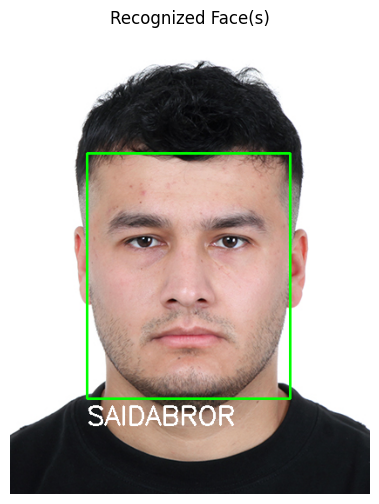

In [6]:
import cv2
import numpy as np
import pickle
import faiss
from insightface.app import FaceAnalysis
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 🔄 Load Faiss index and class names
index = faiss.read_index("faiss_index_cosine.bin")
with open("faiss_names_cosine.pkl", "rb") as f:
    classNames = pickle.load(f)

# 🔁 Initialize InsightFace
model = FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=-1)

# 📷 Load a test image
test_img = cv2.imread('Training_images/saidabror/img1.jpg')
test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# 🔎 Detect face(s) in the image
faces = model.get(test_rgb)

for face in faces:
    # Normalize embedding for cosine similarity
    emb = face.embedding
    emb = emb / np.linalg.norm(emb)
    emb = emb.astype('float32').reshape(1, -1)

    # 🔍 Search top 1 nearest in Faiss index
    D, I = index.search(emb, k=1)
    similarity_score = D[0][0]
    best_match_idx = I[0][0]

    # 🏷️ Threshold check
    if similarity_score > 0.5:  # Experiment with this threshold
        name = classNames[best_match_idx].upper()
    else:
        name = "UNKNOWN"

    # 📦 Draw results
    x1, y1, x2, y2 = face.bbox.astype(int)
    cv2.rectangle(test_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(test_img, name, (x1, y2 + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# 📸 Display image
clear_output(wait=True)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Recognized Face(s)")
plt.show()


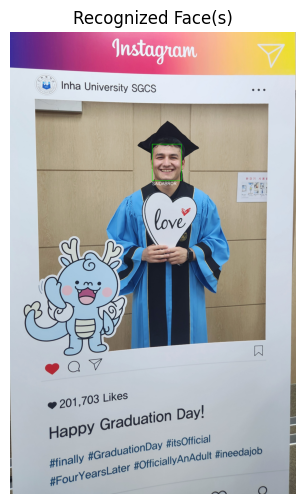

In [7]:
test_img = cv2.imread('test_images/saidabror.jpg')
test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# 🔎 Detect face(s) in the image
faces = model.get(test_rgb)

for face in faces:
    # Normalize embedding for cosine similarity
    emb = face.embedding
    emb = emb / np.linalg.norm(emb)
    emb = emb.astype('float32').reshape(1, -1)

    # 🔍 Search top 1 nearest in Faiss index
    D, I = index.search(emb, k=1)
    similarity_score = D[0][0]
    best_match_idx = I[0][0]

    # 🏷️ Threshold check
    if similarity_score > 0.5:  # Experiment with this threshold
        name = classNames[best_match_idx].upper()
    else:
        name = "UNKNOWN"

    # 📦 Draw results
    x1, y1, x2, y2 = face.bbox.astype(int)
    cv2.rectangle(test_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(test_img, name, (x1, y2 + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# 📸 Display image
clear_output(wait=True)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Recognized Face(s)")
plt.show()


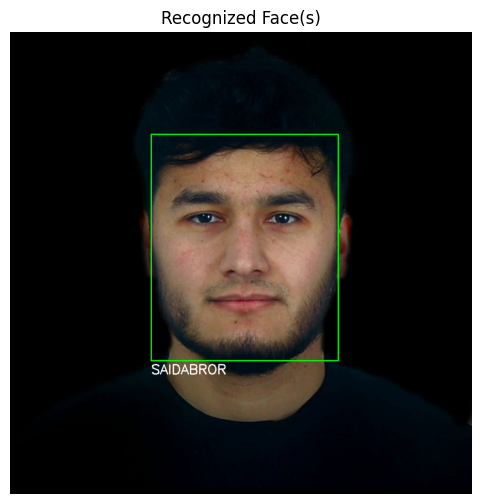

In [8]:
test_img = cv2.imread('test_images/saidabror1.jpg')
test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# 🔎 Detect face(s) in the image
faces = model.get(test_rgb)

for face in faces:
    # Normalize embedding for cosine similarity
    emb = face.embedding
    emb = emb / np.linalg.norm(emb)
    emb = emb.astype('float32').reshape(1, -1)

    # 🔍 Search top 1 nearest in Faiss index
    D, I = index.search(emb, k=1)
    similarity_score = D[0][0]
    best_match_idx = I[0][0]

    # 🏷️ Threshold check
    if similarity_score > 0.5:  # Experiment with this threshold
        name = classNames[best_match_idx].upper()
    else:
        name = "UNKNOWN"

    # 📦 Draw results
    x1, y1, x2, y2 = face.bbox.astype(int)
    cv2.rectangle(test_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(test_img, name, (x1, y2 + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# 📸 Display image
clear_output(wait=True)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Recognized Face(s)")
plt.show()
